In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("../RSCCASN.csv",parse_dates=True,index_col="DATE")

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.columns = ['Sales']

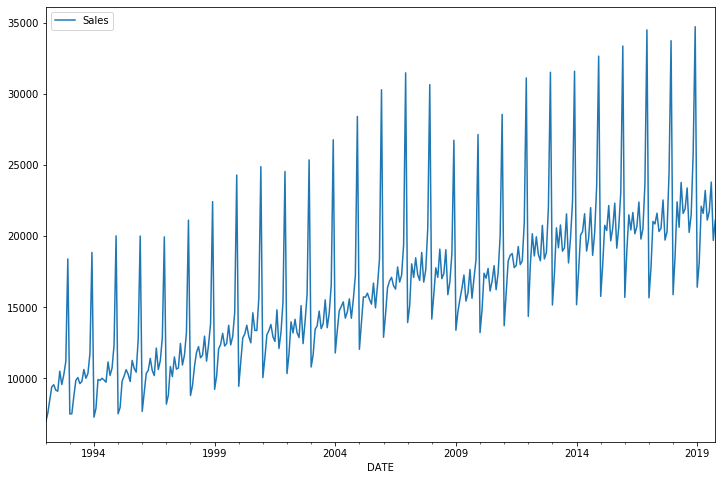

In [5]:
df.plot(figsize=(12,8))

In [6]:
len(df)

334

In [7]:
test_size =18
test_ind = len(df) - test_size


In [8]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [9]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [10]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()


In [14]:
scaled_train = scaler.fit_transform(train)

In [15]:
scaled_test = scaler.transform(test)

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
length= 12
generator = TimeseriesGenerator(scaled_train ,scaled_train , length=length , batch_size=1)

In [24]:
X ,y = generator[0]

In [25]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [26]:
y

array([[0.02047633]])

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [28]:
n_features = 1

In [29]:
model = Sequential()

model.add(LSTM(100 ,activation="relu", input_shape = (length , n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss = 'mse')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
early_stop = EarlyStopping(monitor= "val_loss" , patience = 2)

In [53]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length , batch_size=1)

In [54]:
model.fit_generator(generator, epochs=20,
                   validation_data=validation_generator ,callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/20
304/304 [==============================] - 5s 16ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 2/20
304/304 [==============================] - 5s 16ms/step - loss: 7.7351e-04 - val_loss: 9.7316e-04s: 7.
Epoch 3/20
304/304 [==============================] - 5s 16ms/step - loss: 6.6382e-04 - val_loss: 7.1789e-04
Epoch 4/20
304/304 [==============================] - 5s 16ms/step - loss: 0.0010 - val_loss: 9.2379e-04
Epoch 5/20
304/304 [==============================] - 6s 19ms/step - loss: 0.0011 - val_loss: 6.1814e-04
Epoch 6/20
304/304 [==============================] - 6s 20ms/step - loss: 7.5706e-04 - val_loss: 6.4341e-04
Epoch 7/20
304/304 [==============================] - 6s 20ms/step - loss: 9.8470e-04 - val_loss: 9.2945e-04


In [55]:
losses = pd.DataFrame(model.history.history)

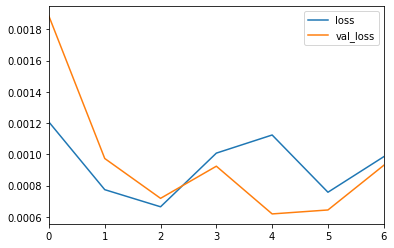

In [56]:
losses.plot()

In [57]:
test_prediction = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_prediction.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [58]:
true_predictions = scaler.inverse_transform(test_prediction)

In [60]:
test['Predictions'] = true_predictions

C:\Users\Milind\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22059.591013
2018-06-01,21589,21038.584837
2018-07-01,21919,21186.294757
2018-08-01,23381,22762.599999
2018-09-01,20260,20491.151397
2018-10-01,21473,21149.460446
2018-11-01,25831,24954.351473
2018-12-01,34706,33258.255717
2019-01-01,16410,16668.902144


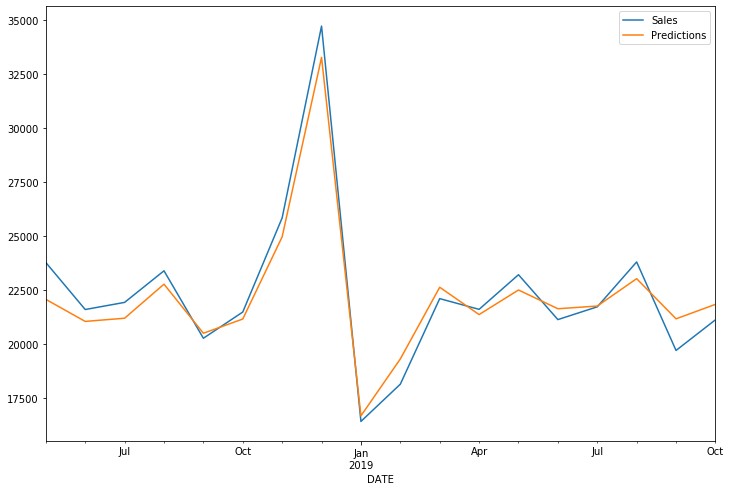

In [62]:
test.plot(figsize=(12,8))

In [63]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [64]:
length =12
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,length= length , batch_size=1)

In [65]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=8)


  ...
    to  
  ['...']
Train for 322 steps
Epoch 1/8
322/322 [==============================] - 7s 21ms/step - loss: 0.0253
Epoch 2/8
322/322 [==============================] - 5s 15ms/step - loss: 0.0196
Epoch 3/8
322/322 [==============================] - 5s 15ms/step - loss: 0.0128
Epoch 4/8
322/322 [==============================] - 5s 15ms/step - loss: 0.0052
Epoch 5/8
322/322 [==============================] - 5s 15ms/step - loss: 0.0040
Epoch 6/8
322/322 [==============================] - 5s 15ms/step - loss: 0.0017: 0s - 
Epoch 7/8
322/322 [==============================] - 5s 16ms/step - loss: 0.0014ETA: 0s - loss:
Epoch 8/8
322/322 [==============================] - 6s 18ms/step - loss: 0.0015


In [67]:
forecast = []

periods =12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length, n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    
    forecast.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [68]:
forecast = scaler.inverse_transform(forecast)

In [69]:
forecast

array([[21726.40434933],
       [20619.59209251],
       [20854.21955824],
       [22711.59245777],
       [20237.80961895],
       [20803.54529238],
       [24799.48188019],
       [34290.65892363],
       [16565.22643113],
       [18797.73846149],
       [22337.47860003],
       [20758.90938425]])

In [70]:
forecast_index = pd.date_range(start='2019-11-01',periods=12,freq="MS") 

In [71]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [72]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns =['Forecast'])

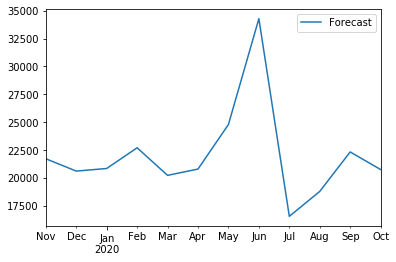

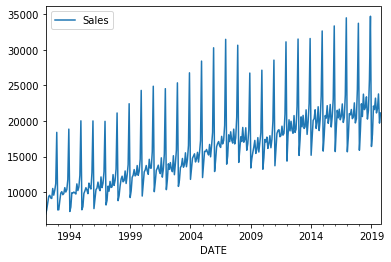

In [74]:
forecast_df.plot()
df.plot()

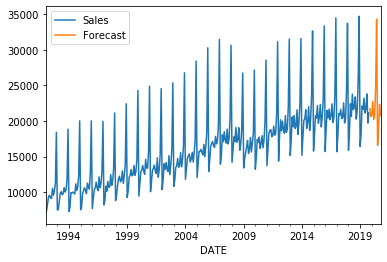

In [75]:
ax = df.plot()
forecast_df.plot(ax = ax)